# Planar GaInP//Si tandem cell

This example is partly based on the structure presented in
[this paper](https://doi.org/10.1109/PVSC40753.2019.9198960), but with planar interfaces instead of a
textured Si surface. This is a four-terminal GaInP/Si device which uses an epoxy and
glass to bond the two cells together mechanically. First, we will do optical-only
calculations to look at the effect of an intermediate anti-reflection coating (on
top of the epoxy/glass) on the
absorption in the bottom Si cell, and then we will use the results of the optical
calculation to do a device simulation and calculate external quantum efficiency and
current-voltage under AM1.5G.

Note: the paper linked above has a GaInP/AlGaInP heterojunction as the top junction.
Because we do not have AlGaInP built in to Solcore's database, this is replaced by a
GaInP homojunction in this example.

In [26]:
from solcore import material, si
from solcore.absorption_calculator import search_db, download_db
import os
from solcore.structure import Layer, Junction
from solcore.solar_cell_solver import solar_cell_solver, default_options
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from solcore.constants import q
import numpy as np
import matplotlib.pyplot as plt

## Defining materials, layers and junctions

The paper referenced above uses a double-layer anti-reflection coating (ARC) made of
MgF$_2$ and ZnS. As in the previous example, we use the interface to the
refractiveindex.info database to select optical constant data from specific sources,
and define Solcore materials using this data. The III-V materials are taken from
Solcore's own material database.

Note that for the epoxy/glass layer, we use only a single material (BK7 glass). The
epoxy and glass used in the paper have the same refractive index (n = 1.56), so we
can use a single material with an appropriate refractive index to represent them.

In [27]:
# download_db(confirm=True) # uncomment to download database

In [28]:
%%capture

MgF2_pageid = search_db(os.path.join("MgF2", "Rodriguez-de Marcos"))[0][0];
ZnS_pageid = search_db(os.path.join("ZnS", "Querry"))[0][0];
MgF2 = material(str(MgF2_pageid), nk_db=True)();
ZnS = material(str(ZnS_pageid), nk_db=True)();

window = material("AlInP")(Al=0.52)
GaInP = material("GaInP")
BSF = material("AlGaAs")(Al=0.5)

epoxy = material("BK7")()

For the Si cell, the front surface has both a low-index and high-index SiN $_x$ layer.
The rear surface uses Al $_2$ O $_3$, and the cell has Al at the rear surface.

In [29]:
SiOx = material("SiO")()
SiN_191_pageid = search_db("Vogt-1.91")[0][0];
SiN_213_pageid = search_db("Vogt-2.13")[0][0];
SiN_191 = material(str(SiN_191_pageid), nk_db=True)();
SiN_213 = material(str(SiN_213_pageid), nk_db=True)();

Si = material("Si")

Al2O3 = material("Al2O3P")()
Al = material("Al")()

Database file found at /Users/z3533914/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
2816	other	SiN	Vogt-1.91	anti-reflective coatings/SiN/Vogt-1.91.yml	1	1	0.25	1.7	146
Database file found at /Users/z3533914/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
2818	other	SiN	Vogt-2.13	anti-reflective coatings/SiN/Vogt-2.13.yml	1	1	0.25	1.7	146


We now define the layers used in the top cell stack: the ARC and window layer for
the top cell, and the GaInP junction itself. The ARC and window layers are not
involved in the electrical calculation using the depletion approximation, so they are
 defined as simple layers, while the GaInP emitter and base are defined as part of a
 `Junction` object.

In [30]:
ARC_window = [
    Layer(97e-9, MgF2),
    Layer(41e-9, ZnS),
    Layer(17e-9, window, role="window"),
]

GaInP_junction = Junction([
    Layer(200e-9, GaInP(In=0.50, Nd=si("2e18cm-3"), hole_diffusion_length=si("300nm")), role="emitter"),
    Layer(750e-9, GaInP(In=0.50, Na=si("1e17cm-3"), electron_diffusion_length=si("800nm")), role="base"),
    Layer(500e-9, BSF, role="bsf")], kind="DA", sn=1, sp=1
)

We now define the spacer layer, with and without a ZnS anti-reflection coating, so we
 can compare their performance in the cell stack. Note that we set the epoxy
 thickness here to be 10 microns, although the real thickness is much higher - this
 is because the epoxy/glass is not absorbing at the wavelengths which are able to
 reach it (which are not absorbed in the GaInP top cell), and we will treat it
 *incoherently* (no thin-film interference), so the exact thickness does not matter.

In [31]:
spacer = [
    Layer(82e-9, ZnS),
    Layer(10e-6, epoxy), # real thickness is much higher, but since this layer is
    # non-absorbing at the relevant wavelength (> 650 nm) and treated incoherently,
    # this does not matter
]

spacer_noARC = [
    Layer(10e-6, epoxy),
]

Now we define the layer stacks for the Si cell, including the front SiO $_x$ /SiN $_x$ 
stack, the junction itself, and the back dielectric layers.

In [32]:
Si_front_surf = [
    Layer(100e-9, SiOx),
    Layer(70e-9, SiN_191),
    Layer(15e-9, SiN_213),
    ]

Si_junction = Junction([
    Layer(1e-6, Si(Nd=si("2e18cm-3"), hole_diffusion_length=2e-6), role="emitter"),
    Layer(150e-6, Si(Na=si("2e15cm-3"), electron_diffusion_length=150e-6), role="base"),
], kind="DA", sn=0.1, sp=0.1)

Si_back_surf = [
    Layer(15e-9, Al2O3),
    Layer(120e-9, SiN_191)
]

## Comparing the optical performance with and without intermediate ARC

Now we will run the calculation. We will treat some of the layers (those above the
epoxy) with a *coherent* TMM calculation, and the epoxy and the layers below it using
 *incoherent* TMM. We will discuss the difference this makes, why this is important,
 and when to use coherent and incoherent layers.

In [33]:
n_coh_layers = len(ARC_window + GaInP_junction)
n_inc_layers = 1 + len(Si_front_surf + Si_junction + Si_back_surf)

wl = np.linspace(300, 1200, 600) * 1e-9

options = default_options
options.recalculate_absorption = True
options.wavelength = wl
options.optics_method = 'TMM'

AM15G = LightSource(source_type="standard", version="AM1.5g", x=wl*1e9,
                    output_units="photon_flux_per_nm")

Now we define two versions of the cell for optical calculations, without and with the
 ZnS anti-reflection coating on the epoxy. Note that we also set the substrate for
 the calculation (aluminium) here.

In [34]:
cell_no_ARC = SolarCell(
    ARC_window + GaInP_junction + spacer_noARC + Si_front_surf + Si_junction +
    Si_back_surf,
    substrate=Al,
)

cell_with_ARC = SolarCell(
    ARC_window + GaInP_junction + spacer + Si_front_surf + Si_junction + Si_back_surf,
    substrate=Al,
)

We set the appropriate coherency list for the structure (a list with entry 'c' for a
 coherent layer or 'i' for an incoherent layer), and solve for the cell optics of the
  cell without the intermediate ARC. We
 get the total absorption in the GaInP and Si junctions.

In [35]:
%%capture

options.coherency_list = ['c']*(n_coh_layers) + ['i']*n_inc_layers
solar_cell_solver(cell_no_ARC, "optics", options)

GaInP_A = cell_no_ARC[3].layer_absorption + cell_no_ARC[4].layer_absorption
Si_A = cell_no_ARC[10].layer_absorption + cell_no_ARC[11].layer_absorption

As above, but for the cell with an intermediate ARC:

In [36]:
options.coherency_list = ["c"]*(n_coh_layers + 1) + ['i']*n_inc_layers
solar_cell_solver(cell_with_ARC, "optics", options)

GaInP_A_ARC = cell_with_ARC[3].layer_absorption + cell_with_ARC[4].layer_absorption
Si_A_ARC = cell_with_ARC[11].layer_absorption + cell_with_ARC[12].layer_absorption

Treating layer(s) 12 incoherently
Calculating RAT...
Calculating absorption profile...


Now we plot the GaInP and Si absorption, and the reflectance of the whole structure,
for both cells:

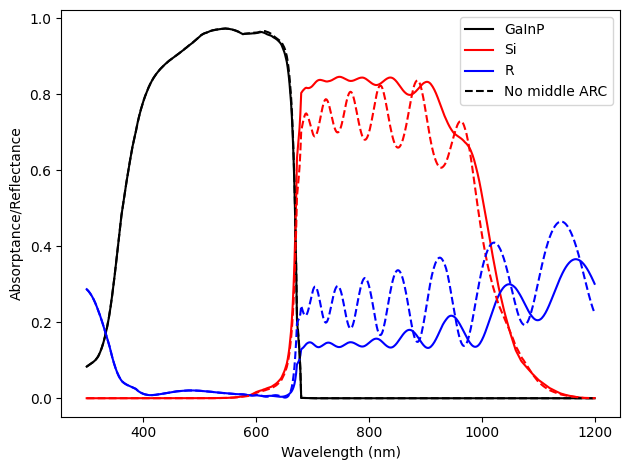

In [37]:
plt.figure()

plt.plot(wl * 1e9, GaInP_A_ARC, "-k", label="GaInP")
plt.plot(wl * 1e9, Si_A_ARC, "-r", label="Si")
plt.plot(wl * 1e9, cell_with_ARC.reflected, '-b', label="R")

plt.plot(wl * 1e9, GaInP_A, "--k", label="No middle ARC")
plt.plot(wl * 1e9, Si_A, "--r")
plt.plot(wl * 1e9, cell_no_ARC.reflected, '--b')

plt.legend(loc='upper right')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorptance/Reflectance")
plt.tight_layout()
plt.show()


We see that the cell without an ARC on the epoxy shows much stronger interference
fringes (due to the thickness of the top stack), and higher reflectance overall in
the long-wavelength region (at short wavelengths, light is absorbed before it is able
 to reach the epoxy at all). Before doing an actual electrical calculation, we will
 calculate the limiting current in both of the sub-cells (assuming all the generated
 charge carriers can be collected):

In [38]:
J_GaInP = q*np.trapz(GaInP_A * AM15G.spectrum()[1], wl*1e9)
J_Si = q*np.trapz(Si_A * AM15G.spectrum()[1], wl*1e9)

print("Limiting short-circuit currents without ARC (mA/cm2): {:.1f} / {:.1f}".format(
      J_GaInP/10, J_Si/10))

J_GaInP_ARC = q*np.trapz(GaInP_A_ARC * AM15G.spectrum()[1], wl*1e9)
J_Si_ARC = q*np.trapz(Si_A_ARC * AM15G.spectrum()[1], wl*1e9)

print("Limiting short-circuit currents with ARC (mA/cm2): {:.1f} / {:.1f}".format(
    J_GaInP_ARC/10, J_Si_ARC/10))

Limiting short-circuit currents without ARC (mA/cm2): 16.4 / 15.5
Limiting short-circuit currents with ARC (mA/cm2): 16.4 / 17.4


As expected from the reduced reflection and increased absorption in the Si, the cell
with an intermediate ARC has significantly higher maximum current in the bottom Si cell.

## EQE and IV calculation

Now, just taking the structure with an intermediate ARC, we do a cell calculation
using the depletion approximation.

In [39]:
options.mpp = True
options.light_iv = True
options.voltages = np.linspace(-1.9, 0.1, 100)
options.light_source = AM15G

solar_cell = SolarCell(
    ARC_window + [GaInP_junction] + spacer + Si_front_surf + [Si_junction] +
    Si_back_surf,
    substrate=Al,
)

First, we calculate and plot the external quantum efficiency (EQE):

Treating layer(s) 12 incoherently
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...


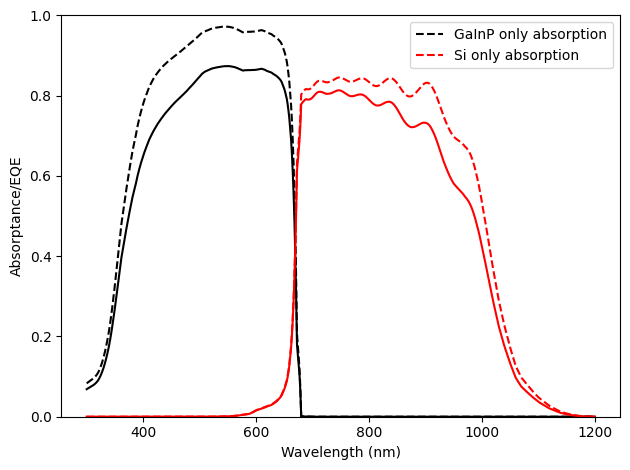

In [40]:
solar_cell_solver(solar_cell, 'qe', options)

plt.figure()
plt.plot(wl * 1e9, GaInP_A_ARC, "--k", label="GaInP only absorption")
plt.plot(wl * 1e9, Si_A_ARC, "--r", label="Si only absorption")
plt.plot(wl*1e9, solar_cell(0).eqe(wl), '-k')
plt.plot(wl*1e9, solar_cell(1).eqe(wl), '-r')
plt.legend(loc='upper right')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorptance/EQE")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

And the current-voltage under AM1.5G:

Treating layer(s) 12 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


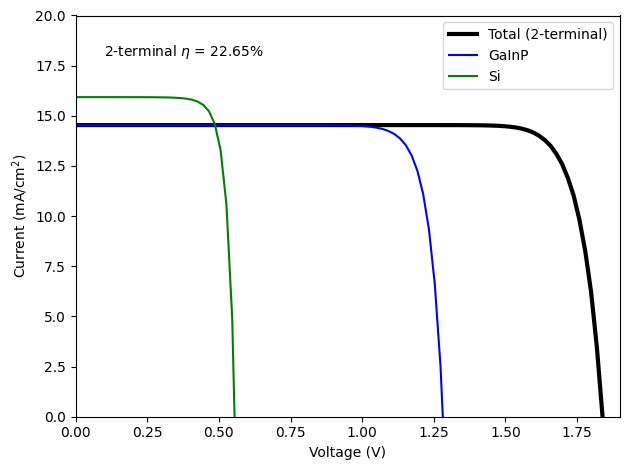

In [41]:
solar_cell_solver(solar_cell, 'iv', options)

plt.figure()
plt.plot(-options.voltages, -solar_cell.iv['IV'][1]/10, 'k', linewidth=3,
         label='Total (2-terminal)')
plt.plot(-options.voltages, solar_cell(0).iv(options.voltages)/10, 'b',
         label='GaInP')
plt.plot(-options.voltages, solar_cell(1).iv(options.voltages)/10, 'g',
         label='Si')
plt.text(0.1, 18, r"2-terminal $\eta$ = {:.2f}%".format(solar_cell.iv["Eta"]*100))
plt.legend()
plt.ylim(0, 20)
plt.xlim(0, 1.9)
plt.ylabel('Current (mA/cm$^2$)')
plt.xlabel('Voltage (V)')
plt.tight_layout()
plt.show()

## Two vs. four-terminal efficiency

By default, Solcore assumes any SolarCell object is a two-terminal device, and will
thus calculate the total I-V curve assuming the cells are connected in series and that
the current is limited by the lowest-current sub-cell. However, it will also
calculate the I-V curves of the individual cells, so we can use this information to
calculate the possible power output in a 4-terminal configuration where the cells
operate independently from an electrical point of view:

(Note: there was a typo/sign error here!)

In [42]:
V = np.linspace(-1.3, 0, 100)
P_GaInP = -V*solar_cell[3].iv(V)
P_Si = -V*solar_cell[9].iv(V)

P_MPP_GaInP = max(P_GaInP)

P_MPP_Si = max(P_Si)

eta_4T = (P_MPP_GaInP + P_MPP_Si)/AM15G.power_density

print('4-terminal efficiency: {:.1f} %'.format(eta_4T*100))

4-terminal efficiency: 22.8 %


## Questions/challenges

- What causes the strange, sharp fringes in the simulation data of
  Fig. 1 in [the reference paper](https://doi.org/10.1109/PVSC40753.2019.9198960)?
  Can you reproduce
  them by modifying this code? Which version of the simulation do you think is
  more correct, and why?
- How could you increase the current in one or both of the sub-cells (remember,
  unlike the paper, we assumed all the layers in the cell are planar!).
- Once the light encounters an 'incoherent' (thick) layer, does it make sense to
  treat any layers below that as coherent?